# Setting Enviornment

In [1]:
!pip install --upgrade ultralytics
!pip install roboflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 88.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.8.93
    Uninstalling nvidia-nvjitlink-cu12-12.8.93:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.8.93
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.9.90
    Uninstalling nvidia-curand-cu12-10.3.

# Getting Data from Roboflow API

In [2]:
from roboflow import Roboflow
rf = Roboflow(api_key="RbA8rOJvkm0XmjH94940")
project = rf.workspace("weeddetection-f7llv").project("weed_d")
version = project.version(1)
dataset = version.download("yolov8")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to weed_d-1 in yolov8:: 100%|██████████| 6598/6598 [00:01<00:00, 4961.02it/s]


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


# Data Exploration

In [3]:
import os
dataset_path = "/kaggle/working/weed_d-1" 
print("Dataset contents:", os.listdir(dataset_path))
print("Valid folder contents:", os.listdir(os.path.join(dataset_path, "valid")))

Dataset contents: ['data.yaml', 'valid', 'train', 'test', 'README.roboflow.txt', 'README.dataset.txt']
Valid folder contents: ['images', 'labels']


In [4]:
import os
train_path = os.path.join(dataset_path, "train", "images")
val_path = os.path.join(dataset_path, "valid", "images")
test_path = os.path.join(dataset_path, "test", "images")

print("Train images:", len(os.listdir(train_path)))
print("Validation images:", len(os.listdir(val_path)))
print("Test images:", len(os.listdir(test_path)))

Train images: 2877
Validation images: 278
Test images: 138


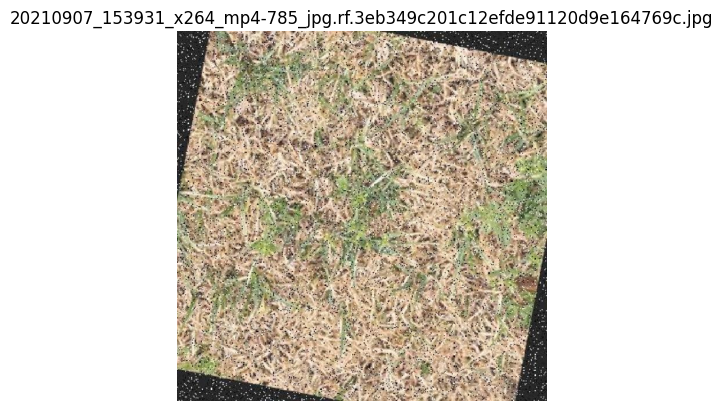

In [5]:
import cv2
import matplotlib.pyplot as plt
import random

def show_random_image(image_folder):
    image_files = os.listdir(image_folder)
    random_image = random.choice(image_files)
    image_path = os.path.join(image_folder, random_image)

    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.imshow(img)
    plt.axis("off")
    plt.title(random_image)
    plt.show()

show_random_image(train_path)

In [6]:
label_path = os.path.join(dataset_path, "train", "labels")
random_label_file = random.choice(os.listdir(label_path))

with open(os.path.join(label_path, random_label_file), "r") as file:
    print(file.read())

0 0.46875 0.43359375 0.26953125 0.23828125


In [7]:
from collections import Counter

class_counts = Counter()
for label_file in os.listdir(label_path):
    with open(os.path.join(label_path, label_file), "r") as file:
        for line in file:
            class_id = line.split()[0] 
            class_counts[class_id] += 1

print("Class Distribution:", class_counts)

Class Distribution: Counter({'0': 7834})


When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.


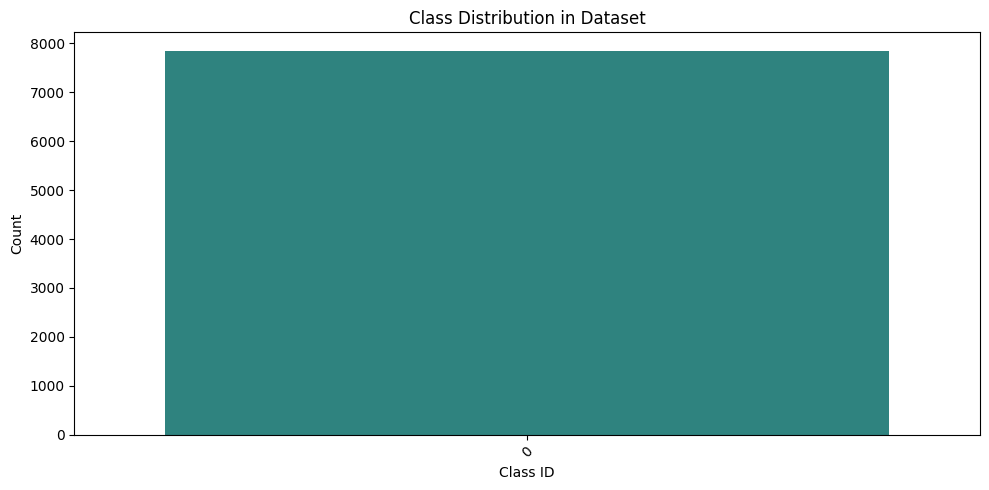

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

classes, counts = zip(*class_counts.items())

# Create a DataFrame
df = pd.DataFrame({
    "Class": classes,
    "Count": counts
})

plt.figure(figsize=(10, 5))
sns.barplot(data=df, x="Class", y="Count", palette="viridis")
plt.xlabel("Class ID")
plt.ylabel("Count")
plt.title("Class Distribution in Dataset")
plt.xticks(rotation=45) 
plt.tight_layout()
plt.show()

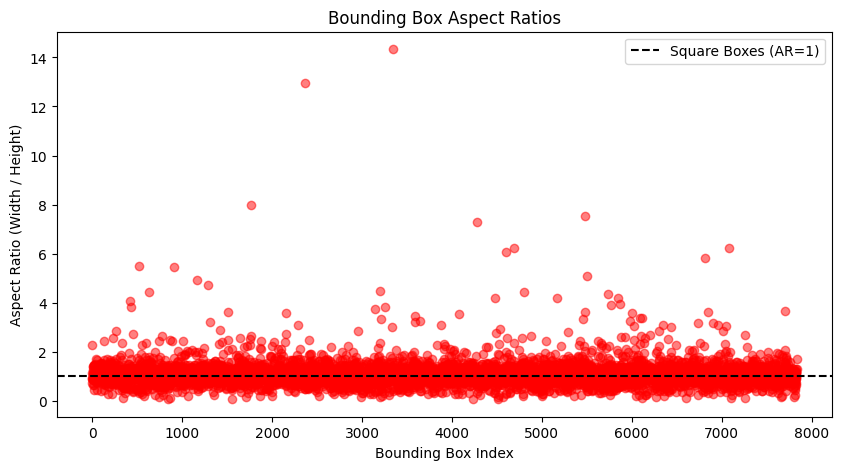

In [9]:
aspect_ratios = []

for label_file in os.listdir(label_path):
    with open(os.path.join(label_path, label_file), "r") as file:
        for line in file:
            _, x_center, y_center, width, height = map(float, line.split())
            aspect_ratio = width / height
            aspect_ratios.append(aspect_ratio)

plt.figure(figsize=(10, 5))
plt.scatter(range(len(aspect_ratios)), aspect_ratios, alpha=0.5, color="red")
plt.axhline(y=1, color="black", linestyle="--", label="Square Boxes (AR=1)")
plt.xlabel("Bounding Box Index")
plt.ylabel("Aspect Ratio (Width / Height)")
plt.title("Bounding Box Aspect Ratios")
plt.legend()
plt.show()

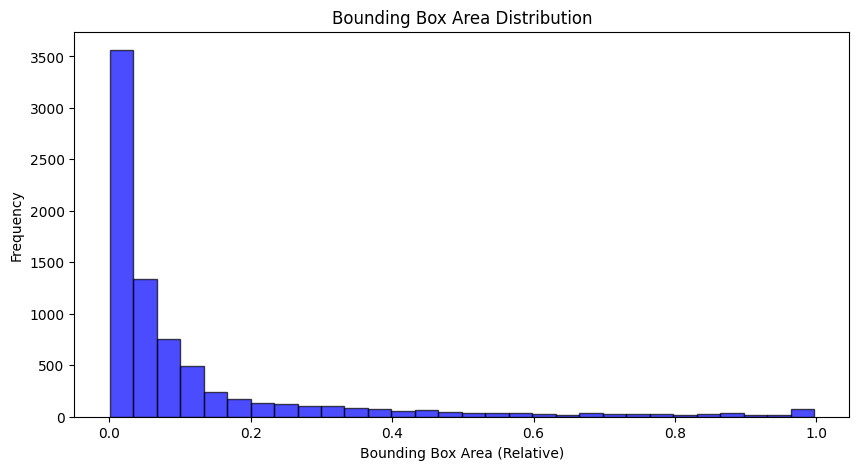

In [10]:
import numpy as np

bbox_areas = []

for label_file in os.listdir(label_path):
    with open(os.path.join(label_path, label_file), "r") as file:
        for line in file:
            _, x_center, y_center, width, height = map(float, line.split())
            area = width * height 
            bbox_areas.append(area)

plt.figure(figsize=(10, 5))
plt.hist(bbox_areas, bins=30, color="blue", alpha=0.7, edgecolor="black")
plt.xlabel("Bounding Box Area (Relative)")
plt.ylabel("Frequency")
plt.title("Bounding Box Area Distribution")
plt.show()

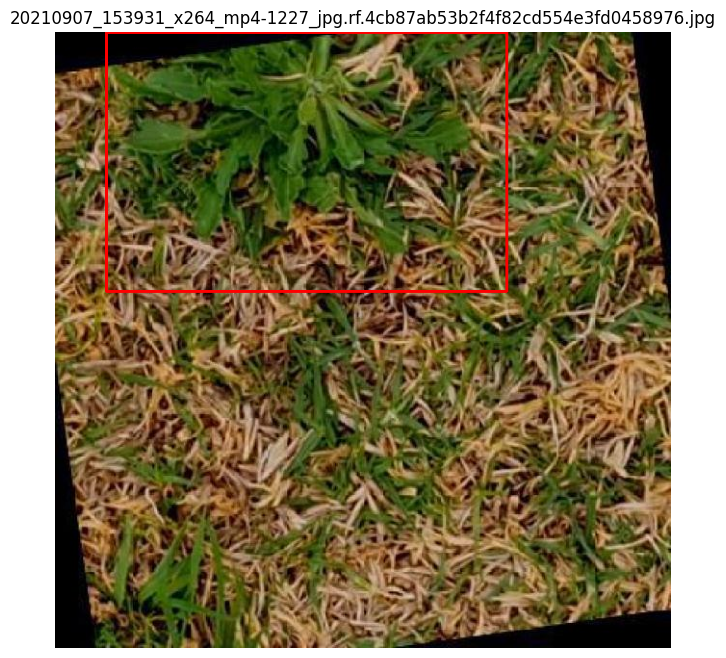

In [11]:
import cv2
import matplotlib.pyplot as plt
import random

# Define paths
image_folder = os.path.join(dataset_path, "train", "images")
label_folder = os.path.join(dataset_path, "train", "labels")

# Selecting a random image
random_image_name = random.choice(os.listdir(image_folder))
image_path = os.path.join(image_folder, random_image_name)

# Corresponding label file
label_file = os.path.join(label_folder, random_image_name.replace(".jpg", ".txt").replace(".png", ".txt"))

# Reading image
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
h, w, _ = image.shape  # Get image dimensions

# Reading annotations
if os.path.exists(label_file):
    with open(label_file, "r") as file:
        for line in file:
            class_id, x_center, y_center, width, height = map(float, line.split())

            # Convert YOLO format to pixel values
            x1 = int((x_center - width / 2) * w)
            y1 = int((y_center - height / 2) * h)
            x2 = int((x_center + width / 2) * w)
            y2 = int((y_center + height / 2) * h)

            # Drawing a bounding box
            cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)
            cv2.putText(image, f"Class {int(class_id)}", (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)

# Showing image with bounding boxes
plt.figure(figsize=(8, 8))
plt.imshow(image)
plt.axis("off")
plt.title(random_image_name)
plt.show()

# Setting data_yaml for Training

In [12]:
data_yaml = """
names:
- Weeds
nc: 1
roboflow:
  license: CC BY 4.0
  project: weed_d
  url: https://universe.roboflow.com/weeddetection-f7llv/weed_d/dataset/1
  version: 1
  workspace: weeddetection-f7llv
train: /kaggle/working/weed_d-1/train/images
val: /kaggle/working/weed_d-1/valid/images
test: /kaggle/working/weed_d-1/test/images
"""

with open(os.path.join(dataset_path, "data.yaml"), "w") as f:
    f.write(data_yaml)

print("data.yaml updated successfully!")

data.yaml updated successfully!


# Training the Model

In [13]:

from ultralytics import YOLO

model = YOLO("yolov8m.pt")

model.train(
    data=os.path.join(dataset_path, "data.yaml"),
    epochs=30,
    imgsz=640,
)

100%|██████████| 49.7M/49.7M [00:00<00:00, 211MB/s]


Ultralytics 8.3.121 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=/kaggle/working/weed_d-1/data.yaml, epochs=30, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_box

100%|██████████| 755k/755k [00:00<00:00, 17.6MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1      1392  ultralytics.nn.modules.conv.Conv             [3, 48, 3, 2]                 
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2    111360  ultralytics.nn.modules.block.C2f             [96, 96, 2, True]             
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    813312  ultralytics.nn.modules.block.C2f             [192, 192, 4, True]           
  5                  -1  1    664320  ultralytics.nn.modules.conv.Conv             [192, 384, 3, 2]              
  6                  -1  4   3248640  ultralytics.nn.modules.block.C2f             [384, 384, 4, True]           
  7                  -1  1   1991808  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 74.5MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1868.7±341.1 MB/s, size: 130.6 KB)


train: Scanning /kaggle/working/weed_d-1/train/labels... 2877 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2877/2877 [00:01<00:00, 1447.86it/s]

train: New cache created: /kaggle/working/weed_d-1/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 902.5±585.3 MB/s, size: 114.2 KB)


val: Scanning /kaggle/working/weed_d-1/valid/labels... 278 images, 0 backgrounds, 0 corrupt: 100%|██████████| 278/278 [00:00<00:00, 1906.14it/s]

val: New cache created: /kaggle/working/weed_d-1/valid/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/train
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      7.78G      1.675      1.875      1.816         49        640: 100%|██████████| 180/180 [01:53<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.77it/s]

                   all        278        714     0.0143      0.556     0.0114    0.00466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      7.81G      1.643      1.598      1.792         42        640: 100%|██████████| 180/180 [01:51<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.34it/s]

                   all        278        714      0.704      0.566       0.63      0.297



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      7.81G      1.597      1.546      1.763         58        640: 100%|██████████| 180/180 [01:51<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.36it/s]

                   all        278        714        0.7      0.632      0.708      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      7.82G      1.522       1.42      1.705         78        640: 100%|██████████| 180/180 [01:51<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.38it/s]

                   all        278        714       0.79      0.702       0.77      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      7.82G      1.473      1.313       1.66         52        640: 100%|██████████| 180/180 [01:51<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.40it/s]

                   all        278        714      0.793      0.681      0.773      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      7.82G      1.426      1.232      1.622         51        640: 100%|██████████| 180/180 [01:51<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.40it/s]

                   all        278        714      0.892      0.737       0.85       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      7.82G       1.39      1.153      1.583         59        640: 100%|██████████| 180/180 [01:51<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.38it/s]

                   all        278        714      0.862       0.72      0.833       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      7.82G      1.361        1.1      1.567         58        640: 100%|██████████| 180/180 [01:51<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.37it/s]

                   all        278        714       0.88      0.811      0.905      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      7.82G      1.329      1.065      1.548         67        640: 100%|██████████| 180/180 [01:51<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.40it/s]

                   all        278        714      0.879      0.847      0.914      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      7.82G      1.321      1.037      1.527         62        640: 100%|██████████| 180/180 [01:51<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.40it/s]

                   all        278        714       0.86      0.849      0.909      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      7.82G      1.295     0.9748      1.511         59        640: 100%|██████████| 180/180 [01:51<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.34it/s]

                   all        278        714       0.91      0.803        0.9      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      7.82G      1.282     0.9501      1.493         69        640: 100%|██████████| 180/180 [01:51<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.39it/s]

                   all        278        714      0.902      0.863      0.932       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      7.82G      1.263     0.9266      1.488         47        640: 100%|██████████| 180/180 [01:51<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.39it/s]

                   all        278        714       0.92      0.856      0.954      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      7.82G      1.244     0.8932      1.464         63        640: 100%|██████████| 180/180 [01:51<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.37it/s]

                   all        278        714      0.867       0.87      0.932      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      7.82G      1.197     0.8506      1.434         72        640: 100%|██████████| 180/180 [01:51<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.39it/s]

                   all        278        714      0.899      0.912      0.961      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      7.82G      1.209      0.852      1.451         56        640: 100%|██████████| 180/180 [01:51<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.39it/s]

                   all        278        714      0.933      0.875      0.949      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      7.82G      1.174     0.8093      1.411         52        640: 100%|██████████| 180/180 [01:51<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.38it/s]

                   all        278        714      0.916      0.884      0.953      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      7.82G      1.177     0.8011      1.413         52        640: 100%|██████████| 180/180 [01:51<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.38it/s]

                   all        278        714      0.937      0.898      0.961      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      7.82G      1.155     0.7895      1.401         69        640: 100%|██████████| 180/180 [01:51<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.40it/s]

                   all        278        714      0.943      0.885      0.962       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      7.82G      1.139     0.7566      1.399         55        640: 100%|██████████| 180/180 [01:51<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.37it/s]

                   all        278        714      0.929      0.921      0.971      0.596


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      7.82G      1.078     0.6245      1.376         27        640: 100%|██████████| 180/180 [01:51<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.39it/s]

                   all        278        714      0.936        0.9      0.969      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      7.82G      1.042     0.5822      1.342         46        640: 100%|██████████| 180/180 [01:51<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.41it/s]

                   all        278        714      0.921      0.933      0.973      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      7.82G       1.01     0.5504       1.31         28        640: 100%|██████████| 180/180 [01:51<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.39it/s]

                   all        278        714      0.946      0.927      0.977      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      7.82G     0.9797     0.5355      1.283         27        640: 100%|██████████| 180/180 [01:51<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.40it/s]

                   all        278        714      0.936      0.922      0.975      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      7.82G     0.9654     0.5155      1.269         72        640: 100%|██████████| 180/180 [01:51<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.41it/s]

                   all        278        714      0.949      0.916      0.979      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      7.82G     0.9316      0.491      1.247         16        640: 100%|██████████| 180/180 [01:51<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.36it/s]

                   all        278        714      0.953      0.908      0.979      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      7.82G     0.9151     0.4822      1.246         39        640: 100%|██████████| 180/180 [01:51<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.38it/s]

                   all        278        714      0.929      0.943      0.981      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      7.82G     0.9029     0.4648      1.232         28        640: 100%|██████████| 180/180 [01:51<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.39it/s]

                   all        278        714      0.941      0.936      0.978      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      7.82G     0.8854     0.4564      1.214         29        640: 100%|██████████| 180/180 [01:51<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.40it/s]

                   all        278        714      0.924      0.959      0.983      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      7.82G     0.8628     0.4429      1.188         32        640: 100%|██████████| 180/180 [01:51<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.40it/s]

                   all        278        714      0.937      0.947      0.979      0.721



30 epochs completed in 0.968 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 52.0MB
Optimizer stripped from runs/detect/train/weights/best.pt, 52.0MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.121 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 92 layers, 25,840,339 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:05<00:00,  1.73it/s]


                   all        278        714      0.938      0.947      0.979      0.721


invalid value encountered in less
invalid value encountered in less


Speed: 0.2ms preprocess, 10.6ms inference, 0.0ms loss, 2.4ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f72e5942150>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 